( some jupyter tricks, just run)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Setup requirements
[here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-environment) is the guide to the development environment setup.

1. install [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/windows.html) (miniconda is fine) 
2. create a new env 

   `conda env create -f environment.yml`
   `conda activate aml`
   
3. setup jupyter

   `conda install notebook ipykernel`
   `ipython kernel install --user --name aml --display-name "aml"`
   
   
4. install azure ml libraries 

   `pip install azureml-core`

## Connect to Workspace

In [ ]:
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="dadbf9da-3f3b-44a8-8097-f3512ff34da8")
from azureml.core import Workspace
ws = Workspace.from_config(auth=interactive_auth)
print('Connected to Workspace',
  '-- name: ' + ws.name,
  '-- Azure region: ' + ws.location,
  '-- Resource group: ' + ws.resource_group,
  sep = '\n')
datastore = ws.get_default_datastore()

# Loading packages

In [ ]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset

# Loading labeled datasets

In [ ]:
ds_path = "../../data/datasets/"
overwrite_data = True
# label file has the folowing columns, pick the one you need for training
# base_label_cols = [
#     "long_label",
#     "long_return",
#     "long_duration",
#     "pt_long_ind",
#     "sl_long_ind",
#     "short_label",
#     "short_return",
#     "short_duration",
#     "pt_short_ind",
#     "sl_short_ind",
#     "end_ind",
# ]

if label_col in [0,5]:
    task = "clf"
elif label_col in [1,6]:
    task ='reg'
else:
    raise Exception("label column index doesn't seem to be right")

ds_dict = {
    "train_dataset_x": "",
    "train_dataset_y": "",
    "train_dataset_w": "",
    "test_dataset_x": "",
    "test_dataset_y": "",
    "test_dataset_w": "",
}
for ds_name in ds_dict:
    print(f"fetching {ds_name}")
    dataset = Dataset.get_by_name(ws, name=ds_name)
    r = dataset.download(target_path=ds_path, overwrite=overwrite_data)
    ds_dict[ds_name] = r[0]

In [ ]:
print("dataset names and their local paths:")
print(ds_dict)
ds_dict_bu = ds_dict

In [ ]:
label_col =1
task = "reg"
print (f"label col {label_col}, task {task}")

In [ ]:
X_train = np.load(ds_dict["train_dataset_x"])
y_train_all = np.load(ds_dict["train_dataset_y"])
y_train = y_train_all[:,label_col].reshape(len(y_train_all))
w_train = np.load(ds_dict["train_dataset_w"])
w_train = w_train.reshape(len(w_train))


X_test = np.load(ds_dict["test_dataset_x"])
y_test_all = np.load(ds_dict["test_dataset_y"])

y_test = y_test_all[:,label_col].reshape(len(y_test_all))
ret_test = y_test_all[:,1].reshape(len(y_test_all)) #TODO: fix for short
hold_test = y_test_all[:,2].reshape(len(y_test_all)) #TODO: fix for short

w_test = np.load(ds_dict["test_dataset_w"])
w_test = w_test.reshape(len(w_test))

if task == "clf":
    #Changing [-1,0,1] labels to [0,1,2] labels
    y_train+=1
    y_test+=1
print(
    "shapes of X_train {}, y_train, {}, w_train {}, X_test {}, y_test {}, w_test {}".format(
        X_train.shape, y_train.shape, w_train.shape, X_test.shape, y_test.shape, w_test.shape
    )
)

In [ ]:
y_test[0]

In [ ]:
y_test[50]

# Prepare training data

In [ ]:
sys.path.insert(0, '../src/utils')
from data_utils import build_timeseries

`time_steps` defines how many samples are used for each training round. We can use data at time t0 to predict result at time t0,or we can include n previous data points as well, in that case, time steps is equal n.
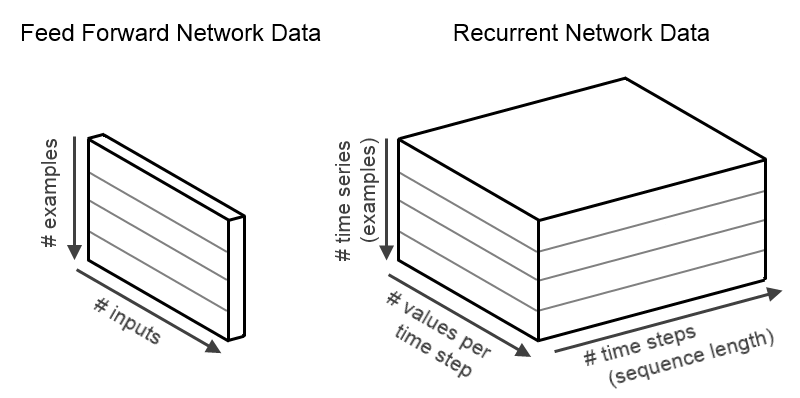

so, the training data can be a sequence and hence 3d. 
Weights and labels are 1d

In [ ]:
time_steps = 1

In [ ]:
X_train_3d, y_train_1d, w_train_1d = build_timeseries(X_train, y_train, steps = time_steps, weights=w_train) 
X_test_3d, y_test_1d, w_test_1d = build_timeseries(X_test, y_test, steps = time_steps, weights=w_test) 
ret_test_1d = ret_test[time_steps:]
w_train_1d = w_train[time_steps:]
w_test_1d = w_test[time_steps:]
hold_test_1d = hold_test[time_steps:]

The 3d structure can be fed into lstm, but for traditional ML, we need to seralize this 3d data structure into 2d.

In [ ]:
X_train_2d = X_train_3d.reshape(X_train_3d.shape[0],X_train_3d.shape[1]*X_train_3d.shape[2])
X_test_2d = X_test_3d.reshape(X_test_3d.shape[0],X_test_3d.shape[1]*X_test_3d.shape[2])


print(
    "shapes of X_train_2d {}, y_train, {}, X_test_2d {}, y_test_2d {}".format(
        X_train_2d.shape, y_train_1d.shape, X_test_2d.shape, y_test_1d.shape
    )
)

# Training

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from joblib import dump, load

## Logistic Regression (triple barrier classification)

In [ ]:
name = "LR"
model = LogisticRegression()
model.fit(X_train_2d, y_train_1d, sample_weight=w_train_1d)
y_pred_flat = model.predict(X_test_2d)
cm = confusion_matrix(y_test_1d, y_pred_flat)

print("{} gain precision: {:.2f}".format(name, cm[2,2]/sum(cm[:,2])))
print(classification_report(y_test_1d, y_pred_flat, target_names=['loss','no hit','gain']))


# Linrear Regression

In [ ]:
name = "LinearRegression"
model = LinearRegression()
model.fit(X_train_2d, y_train_1d)#, sample_weight=w_train_2d)
y_pred = model.predict(X_test_2d)

In [ ]:
y_pred_bin =[1 if y>0 else 0 for y in y_pred]
y_test_2d_bin = [1 if y>0 else 0 for y in y_test_1d]
# y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test_2d_bin, y_pred_bin, target_names=['loss','gain']))

# Registring the model

In [ ]:
os.makedirs('outputs', exist_ok=True)
load_model_path = f'outputs/{name}_{time_steps}_{task}.pkl'
dump(model, load_model_path) 

In [ ]:
from azureml.core import Model

model = Model.register(workspace=ws,
                       model_name=f'{name}_{time_steps}_{task}',
                       model_path=load_model_path, # local path
                       description='A classification model',
                       tags={'data-format': '2d array'},
                       model_framework=Model.Framework.SCIKITLEARN,
                       model_framework_version='0.20.3')

# Ignore

In [ ]:
train_data = lightgbm.Dataset(X_train_2d, label=y_train_2d, weight = w_train_2d)
# val_data = lightgbm.Dataset(X_val_2d, label=y_val, reference=train_data)
test_data = lightgbm.Dataset(X_test_2d, label=y_test_2d)#, weight = w_test_2d)

In [ ]:
parameters = {
    'objective': 'multiclass',
#     'metric': 'multi_logloss,auc_mu',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_class':3,
    'metric_freq': 1,
    'is_training_metric':'true',
    'learning_rate':0.05,
    'num_leaves': 5,
    'num_trees':100,
    'feature_fraction': 0.43,
    'bagging_fraction': 0.48,
    'bagging_freq': 4,
    'min_data_in_leaf':50,
    'learning_rate': 0.05,
    'verbose': 1,
    'early_stopping_round':10
}

In [ ]:
print('Starting training...')
# train
gbm = lightgbm.train(params=parameters,
                     train_set = train_data,
                     valid_sets=[train_data,test_data])

In [ ]:
y_pred = gbm.predict(X_test_2d)
y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test_2d, y_pred_flat, target_names=['loss','no hit','gain']))


In [ ]:
single_unit_trade(y_pred_flat, ret_test_2d, hold_test_2d, w_test_2d, labels=[0,1,2]) 

In [ ]:
np.mean(w_test_2d)

In [ ]:
w_test_2d.